In [14]:
import talib as ta

from datetime import datetime
import pandas as pd
import numpy as np
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, auc, mean_squared_error, confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

def get_score(model, y_pred):
    print('train: {}'.format(model.score(x_train, y_train) * 100))
    print('test: {}'.format(model.score(x_test, y_test) * 100))
    print('accuracy score: {}'.format(accuracy_score(y_final, y_pred) * 100))


def return_plot(estimator, plot=False, deep=False):
    #df['Returns'] = df.Close.pct_change()
    df['Predicted_Signal'] = estimator.predict(x)
    if deep:
        df.Predicted_Signal[df['Predicted_Signal'] >= 0.5] = 1
        df.Predicted_Signal[df['Predicted_Signal'] < 0.5] = -1
    else:
        df.Predicted_Signal[df['Predicted_Signal'] == 0] = -1
    Cumulative_returns = np.cumsum(df.iloc[split+half_split:]['Returns'])
    df['Startegy_returns'] = df['Returns']* df['Predicted_Signal'].shift(1)
    Cumulative_Strategy_returns = np.cumsum(df.iloc[split+half_split:]['Startegy_returns'])
    print('Return: {}%'.format(round(Cumulative_Strategy_returns[-1] * 100), 2))
    
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(Cumulative_returns, color='r',label = 'Returns')
        plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
        plt.legend()
        plt.show()
        
def roc_plot(estimator, auc_cv=False, title="ROC Curve"):
    y_pred = estimator.predict(x_final)
    y_pred_prob = estimator.predict_proba(x_final)[:,1]
    fpr, tpr, thresholds = roc_curve(y_final, y_pred_prob)
    print("Final Score: {}%".format(round(estimator.score(x_final, y_final)*100, 2)))
    print(confusion_matrix(y_final, y_pred))
    print(classification_report(y_final, y_pred))

    # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.show()

    #If the AUC is greater than 0.5, the model is better than random guessing. Always a good sign!
    print("AUC: {}%".format(round(roc_auc_score(y_final, y_pred_prob)*100, 2)))
    
    if (auc_cv):
        cv_auc = cross_val_score(estimator, X, y, cv=5, scoring='roc_auc', n_jobs=-1)
        print("AUC scores computed using 5-fold cross-validation: {}%".format(round(np.mean(cv_auc)*100, 2)))

def history_plot(histories, key='acc'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

def create_multivariate_rnn_data(x, y, window_size):
    y = y[window_size:]
    n = x.shape[0]
    x = np.stack([x[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return x, y

df = pd.read_csv('data/data3_M5.csv', parse_dates=['Datetime'], index_col='Datetime')
x = df.drop('Target', axis=1).values
x = MinMaxScaler().fit_transform(x)
pca = PCA(n_components=.8).fit(x)
x = pca.transform(x)
y = df.Target.values
y = y.reshape(-1,1)

#X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.40, random_state=42)

split = int(len(x)*0.60)
x_train, x_tmp = x[:split], x[split:]
y_train, y_tmp = y[:split], y[split:]

half_split = int(len(x_tmp) / 2)
x_test = x_tmp[:half_split]
x_final = x_tmp[half_split:]
y_test = y_tmp[:half_split]
y_final = y_tmp[half_split:]

n_cols = x_train.shape[1]
print(x_train.shape)

(697555, 3)


In [ ]:
C = [0.00001, 0.0001, 0.001, 0.01, 0.10]
for n in C:
    model = SVC(C=n)
    model.fit(x_train, y_train)
    train_score.append(model.score(x_train, y_train))
    test_score.append(model.score(x_test, y_test))

/home/ballmdr/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ballmdr/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [15]:
SVC()

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
print(np.argmax(test_score))
print(test_score[np.argmax(test_score)])

In [2]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_acc')

In [3]:
base = keras.Sequential([
    keras.layers.Dense(200, input_shape=(n_cols, )),
    keras.layers.Dense(400, activation=tf.nn.relu),
    keras.layers.Dense(400, activation=tf.nn.relu),
    keras.layers.Dense(400, activation=tf.nn.relu),
    keras.layers.Dense(200),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
base.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy', 'binary_accuracy'])
base_history = base.fit(x_train, y_train, epochs=200, callbacks=[early_stop], validation_split=0.3, validation_data=(x_test, y_test), batch_size=32, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Train on 697555 samples, validate on 232519 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 57s - loss: 0.6918 - acc: 0.5256 - binary_crossentropy: 0.6918 - binary_accuracy: 0.5256 - val_loss: 0.6913 - val_acc: 0.5276 - val_binary_crossentropy: 0.6913 - val_binary_accuracy: 0.5276
Epoch 2/200
 - 53s - loss: 0.6915 - acc: 0.5266 - binary_crossentropy: 0.6915 - binary_accuracy: 0.5266 - val_loss: 0.6918 - val_acc: 0.5278 - val_binary_crossentropy: 0.6918 - val_binary_accuracy: 0.5278
Epoch 3/200
 - 53s - loss: 0.6915 - acc: 0.5270 - binary_crossentropy: 0.6915 - binary_accuracy: 0.5270 - val_loss: 0.6912 - val_acc: 0.5275 - val_binary_crossentropy: 0.6912 - val_binary_accuracy: 0.5275
Epoch 4/200
 - 53s - loss: 0.6915 - acc: 0.5274 - binary_crossentropy: 0.6915 - binary_accuracy: 0.5274 - val_loss: 0.6912 - val_acc: 0.5262 - val_binary_crossentropy: 0.6912 - val_binary_accuracy: 0.5262
Epoch 5/

Epoch 38/200
 - 53s - loss: 0.6914 - acc: 0.5273 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5273 - val_loss: 0.6912 - val_acc: 0.5262 - val_binary_crossentropy: 0.6912 - val_binary_accuracy: 0.5262
Epoch 39/200
 - 52s - loss: 0.6914 - acc: 0.5271 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5271 - val_loss: 0.6913 - val_acc: 0.5262 - val_binary_crossentropy: 0.6913 - val_binary_accuracy: 0.5262
Epoch 40/200
 - 53s - loss: 0.6914 - acc: 0.5272 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5272 - val_loss: 0.6911 - val_acc: 0.5273 - val_binary_crossentropy: 0.6911 - val_binary_accuracy: 0.5273
Epoch 41/200
 - 52s - loss: 0.6914 - acc: 0.5274 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5274 - val_loss: 0.6911 - val_acc: 0.5278 - val_binary_crossentropy: 0.6911 - val_binary_accuracy: 0.5278
Epoch 42/200
 - 53s - loss: 0.6914 - acc: 0.5273 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5273 - val_loss: 0.6914 - val_acc: 0.5264 - val_binary_crossentropy: 0.6914 

Epoch 78/200
 - 51s - loss: 0.6913 - acc: 0.5275 - binary_crossentropy: 0.6913 - binary_accuracy: 0.5275 - val_loss: 0.6913 - val_acc: 0.5262 - val_binary_crossentropy: 0.6913 - val_binary_accuracy: 0.5262
Epoch 79/200
 - 51s - loss: 0.6913 - acc: 0.5276 - binary_crossentropy: 0.6913 - binary_accuracy: 0.5276 - val_loss: 0.6912 - val_acc: 0.5292 - val_binary_crossentropy: 0.6912 - val_binary_accuracy: 0.5292
Epoch 80/200
 - 50s - loss: 0.6914 - acc: 0.5274 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5274 - val_loss: 0.6910 - val_acc: 0.5281 - val_binary_crossentropy: 0.6910 - val_binary_accuracy: 0.5281
Epoch 81/200
 - 53s - loss: 0.6914 - acc: 0.5271 - binary_crossentropy: 0.6914 - binary_accuracy: 0.5271 - val_loss: 0.6910 - val_acc: 0.5286 - val_binary_crossentropy: 0.6910 - val_binary_accuracy: 0.5286
Epoch 82/200
 - 50s - loss: 0.6913 - acc: 0.5275 - binary_crossentropy: 0.6913 - binary_accuracy: 0.5275 - val_loss: 0.6911 - val_acc: 0.5279 - val_binary_crossentropy: 0.6911 

Epoch 118/200
 - 54s - loss: 0.6916 - acc: 0.5273 - binary_crossentropy: 0.6916 - binary_accuracy: 0.5273 - val_loss: 0.6915 - val_acc: 0.5262 - val_binary_crossentropy: 0.6915 - val_binary_accuracy: 0.5262
Epoch 119/200
 - 54s - loss: 0.6916 - acc: 0.5273 - binary_crossentropy: 0.6916 - binary_accuracy: 0.5273 - val_loss: 0.6914 - val_acc: 0.5262 - val_binary_crossentropy: 0.6914 - val_binary_accuracy: 0.5262
Epoch 120/200
 - 55s - loss: 0.6916 - acc: 0.5273 - binary_crossentropy: 0.6916 - binary_accuracy: 0.5273 - val_loss: 0.6916 - val_acc: 0.5262 - val_binary_crossentropy: 0.6916 - val_binary_accuracy: 0.5262
Epoch 121/200
 - 54s - loss: 0.6916 - acc: 0.5274 - binary_crossentropy: 0.6916 - binary_accuracy: 0.5274 - val_loss: 0.6915 - val_acc: 0.5262 - val_binary_crossentropy: 0.6915 - val_binary_accuracy: 0.5262
Epoch 122/200
 - 54s - loss: 0.6916 - acc: 0.5273 - binary_crossentropy: 0.6916 - binary_accuracy: 0.5273 - val_loss: 0.6914 - val_acc: 0.5262 - val_binary_crossentropy: 0.

In [10]:
score = base.evaluate(x_final, y_final)
print('final accuracy: ', score)

232519/232519 [==============================] - 6s 25us/sample - loss: 0.6919 - acc: 0.5220 - binary_crossentropy: 0.6919 - binary_accuracy: 0.5220
final accuracy:  [0.6919257775498224, 0.52203906, 0.691924, 0.52203906]


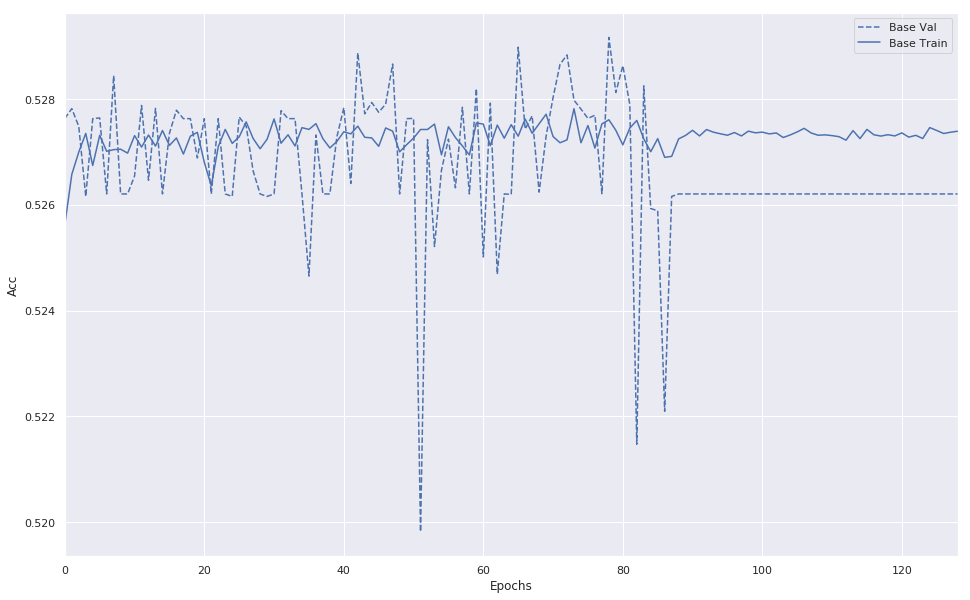

In [7]:
history_plot([('base', base_history)])

/home/ballmdr/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ballmdr/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ballmdr/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting 

Return: 85.0%


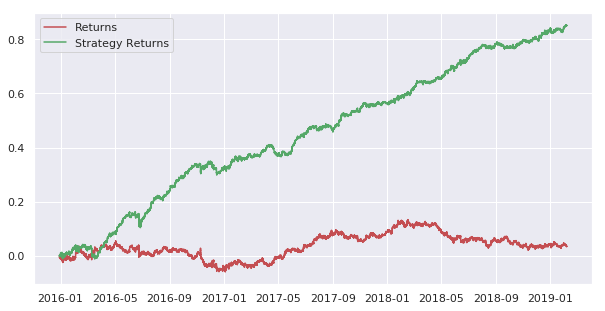

In [8]:
return_plot(base, plot=True, deep=True)

In [11]:
roc_plot(base)

IndexError: index 1 is out of bounds for axis 1 with size 1

In [12]:
base.save('base_test_data3_m5.h5')

In [215]:
test_score = []
train_score = []
max_depth = np.arange(1,50)
criterion = ['gini', 'entropy']
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [None,2,3,4,5,6,7,8,9,10,11,12,15,20]
class_weight = [None,'balanced']
presort = [True, False]
splitter = ['best', 'random']
min_weight_fraction_leaf = np.logspace(-4,0.5,0.01)
for n in min_weight_fraction_leaf:
    model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10, min_weight_fraction_leaf=n)
    model.fit(x_train, y_train)
    train_score.append(model.score(x_train, y_train))
    test_score.append(model.score(x_test, y_test))

In [216]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

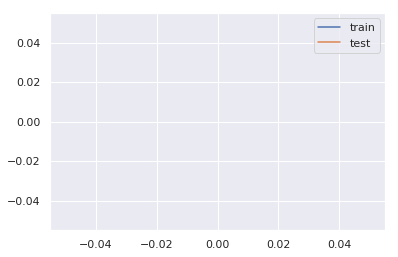

In [217]:
plt.plot(train_score, label='train')
plt.plot(test_score, label='test')
plt.legend()
plt.show()

In [213]:
print(np.argmax(test_score))
print(test_score[np.argmax(test_score)])

0
0.5314791479405984


In [205]:
max_leaf_nodes[9]

10

In [175]:
with open('log_test_data3_m5.pickle', 'wb') as file:
    pickle.dump(model, file)

train: 52.91123997390886
test: 53.14791479405984
accuracy score: 52.483452965134035


/home/ballmdr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Return: 75.0%


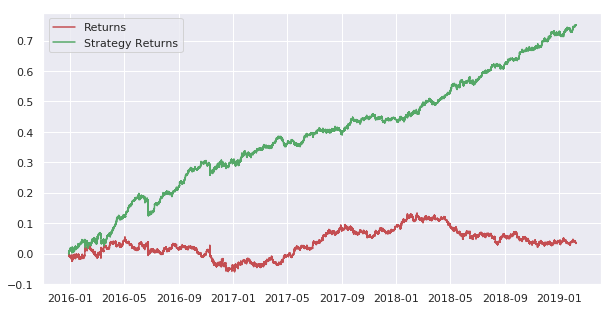

Final Score: 52.48%
[[79979 39026]
 [71459 42055]]
              precision    recall  f1-score   support

           0       0.53      0.67      0.59    119005
           1       0.52      0.37      0.43    113514

   micro avg       0.52      0.52      0.52    232519
   macro avg       0.52      0.52      0.51    232519
weighted avg       0.52      0.52      0.51    232519



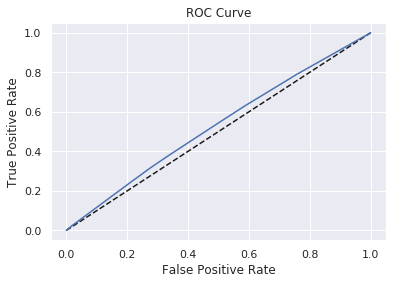

AUC: 52.97%


In [218]:
model = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=10).fit(x_train, y_train)
y_pred = model.predict(x_final)
get_score(model, y_pred)
return_plot(model, plot=True)
roc_plot(model)